In [9]:
import sys  
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None
# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *

# tai from ... import *


# Jos datasetti on "df"

# Esim. find_outliers(df)
# Esim. draw_histogram(df['x'], df['y'], 20) <-- kolmas meinaa bins arvoa, eli histogrammin "rakeisuutta"

# Database query

In [23]:
df = database_query("SELECT * FROM SensorData LIMIT 10000;")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Histogram of x and y coordinates

x mean:  1933.45561
y mean:  581.71249
x std:  874.0018203696877
y std:  1035.9577992022648


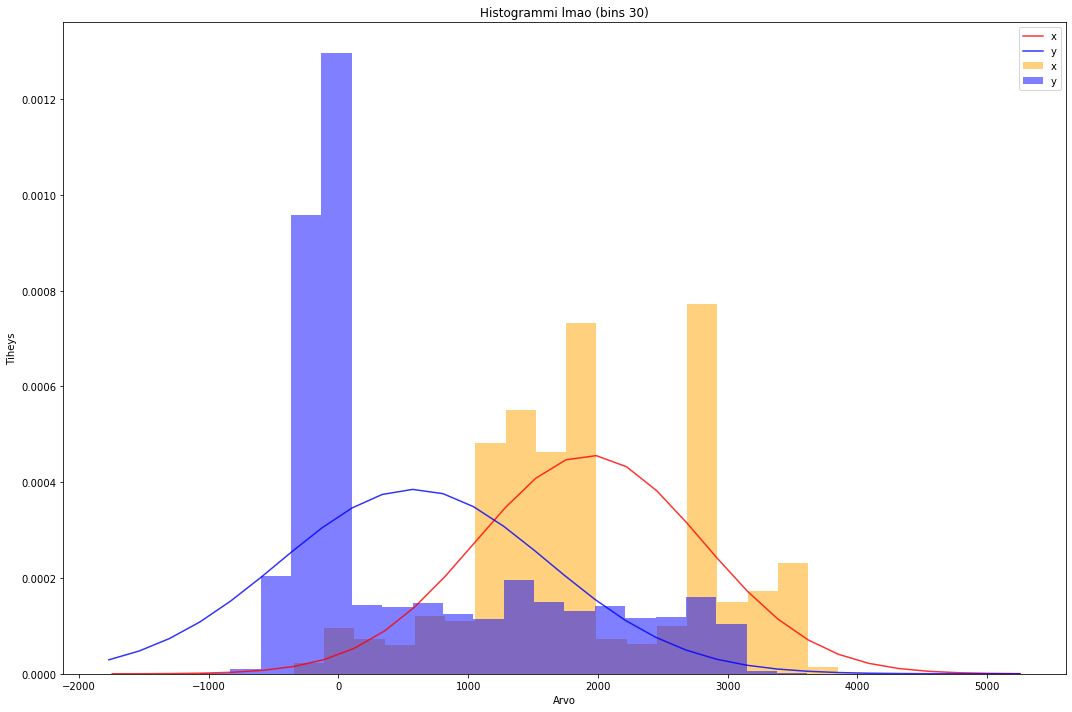

In [4]:
draw_histogram(df['x'], df['y'], 30)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 2549
uniques in y 2778
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  10000
Ouliers removed:     152
Data after:  9848


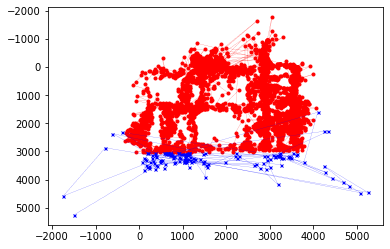

In [71]:
df1 = find_outliers(df)

In [445]:
dftest = df1.copy()

In [462]:
#dftest['node_id'].count(dftest['node_id'].unique())
print(dftest["node_id"].unique())
#dftest['node_id'].count("b'-2393099149039893833'")
#[[x,dftest['node_id'].count(x)] for x in set(dftest['node_id'])]
from collections import Counter
#Counter(df["node_id"])

_count = Counter()
_count.update(dftest["node_id"])
print('%s : %d' % (dftest["node_id"].unique()[0], _count[dftest["node_id"].unique()[0]]))

[b'-2393099149039893833']
b'-2393099149039893833' : 8183


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


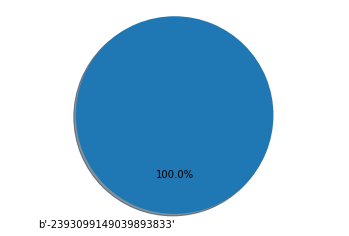

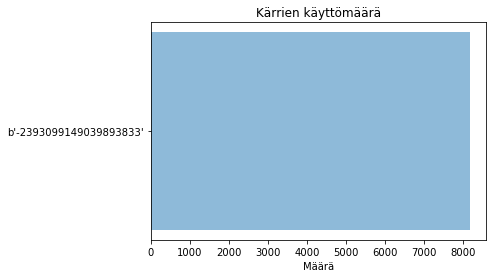

In [468]:
#nodes = dftest.rename(columns={'COUNT(node_id)': 'amount'})
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = dftest["node_id"].unique()
sizes =  _count[dftest["node_id"].unique()[0]]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

objects = dftest["node_id"].unique()
y_pos = np.arange(len(objects))
performance = _count[dftest["node_id"].unique()[0]]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Määrä')
plt.title('Kärrien käyttömäärä')

plt.show()

### Kärrien liikkeet tietyllä päivällä

In [397]:
def convert_timestamp(df):    
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(2, -8)

    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    df['timestamp'] = pd.Series(df['timestamp']).dt.round("S")
    df['timestamp'] = df['timestamp'].dt.date

    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

convert_timestamp(dftest)

In [405]:
dftest['timestamp'].unique()[0]

numpy.datetime64('2020-06-25T00:00:00.000000000')

[numpy.datetime64('2020-06-24T00:00:00.000000000')]


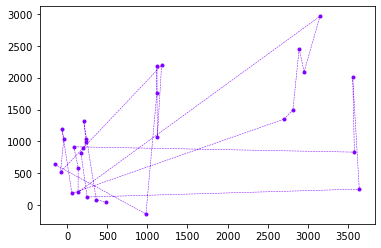

In [410]:
from matplotlib.pyplot import cm
from cycler import cycler

dates = [dftest['timestamp'].unique()[1]]
print(dates)
n = len(dates)
colors=iter(cm.rainbow(np.linspace(0,1,n)))

for i in dates:
    tsT = dftest.loc[dftest['timestamp'] == i, :]
    c=next(colors)
    plt.plot(tsT.x, tsT.y,marker='o', linestyle='dashed', linewidth=0.5, markersize=3, color=c)

### Poistetaan liiat nopeudet

In [73]:
import numpy as np

table_alkuperäinen = len(df1['x'])

prev = 0
val = 0
def calc_velocity(time_start, time_end):
    
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    
    if(diff_time > 0.1):
        return diff_time
    else:
        return 0.1
    
    

x = 0
for i in range(len(df1['x'])):
    
    if(i < len(df1['x'])):
        
        value1 = calc_velocity(df1.iloc[i-x, 1], df1.iloc[i-(1+x), 1])
        
        value2 = int((abs(df1.iloc[i-x, 2])) - prev)
        val =  value2 / value1
        
        if (val > 60 or value2 > 100):
            df1.drop([df1.index[i-x]], axis = 0, inplace = True)
            prev = abs(df1.iloc[i-x, 2])
            x +=1
        else:
            prev = abs(df1.iloc[i-x, 2])
x = 0
for i in range(len(df1['y'])):
    
    if(i < len(df1['y'])):
        
        value1 = calc_velocity(df1.iloc[i-x, 1], df1.iloc[i-(1+x), 1])
        value2 = int((abs(df1.iloc[i-x, 3]))-prev)
        val = value2 / value1
        
        if (val > 60 or value2 > 100):
            df1.drop([df1.index[i-x]], axis = 0, inplace = True)
            prev = abs(df1.iloc[i-x , 3])
            x +=1
        else:
            prev = abs(df1.iloc[i-x, 3])
        
print(len(df1['x']))
print("Poistettuja pisteitä: ", table_alkuperäinen - len(df1['x']))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':


8183
Poistettuja pisteitä:  1665


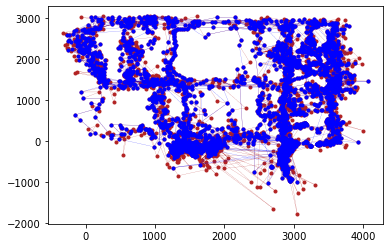

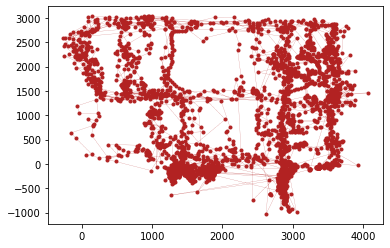

In [75]:
import matplotlib.pyplot as plt

plt.plot(dftest['x'], dftest['y'], color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.plot(df1['x'], df1['y'], color="blue", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show()
plt.plot(df1['x'], df1['y'], color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show()

In [167]:
df1 = xy_to_grid(df1, df1.x, df1.y, 50)
df1

,node_id,timestamp,x,y,z,q,x_grid,y_grid,xy_grid
0,b'-2393099149039893833',b'2020-06-25 14:18:22.644674+00:00',-253,2220,100,0,0,39,1
1,b'-2393099149039893833',b'2020-06-25 14:18:18.644931+00:00',-190,2248,100,0,0,40,2
2,b'-2393099149039893833',b'2020-06-26 16:23:37.645032+00:00',-206,2415,100,0,0,42,3
3,b'-2393099149039893833',b'2020-06-26 16:23:37.645025+00:00',-256,2429,100,0,0,42,3
4,b'-2393099149039893833',b'2020-06-26 16:23:38.645267+00:00',-240,2461,100,0,0,42,3
...,...,...,...,...,...,...,...,...,...
8178,b'-2393099149039893833',b'2020-06-25 13:09:41.64499+00:00',590,2876,100,0,9,48,925
8179,b'-2393099149039893833',b'2020-06-26 16:06:22.645222+00:00',564,2911,100,0,9,48,925
8180,b'-2393099149039893833',b'2020-06-25 14:17:26.645187+00:00',588,2925,100,0,9,48,925
8181,b'-2393099149039893833',b'2020-06-26 16:22:51.645162+00:00',562,2959,100,0,9,49,926


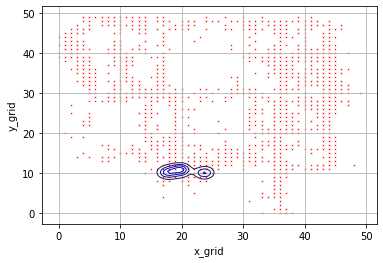

In [175]:
sns.scatterplot(df1['x_grid'], df1['y_grid'], s=5, color="r")
#plt.plot(df1['x'], df1['y'], color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
sns.kdeplot(df1['x_grid'], df1['y_grid'], levels=5, color="b", linewidths=1)
#sns.histplot(df1['x'], df1['y'], bins=50, pthresh=.1, cmap="mako")
plt.grid()
plt.show()

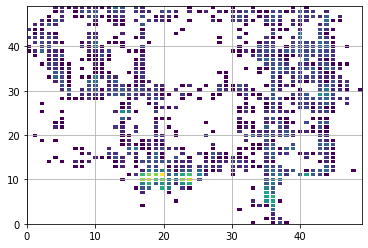

In [194]:
from matplotlib import colors
plt.hist2d(df1['x_grid'], df1['y_grid'], bins = 100, norm = colors.LogNorm())#bins=[np.arange(0,400,5),np.arange(0,300,5)]
# Loop over data dimensions and create text annotations.
plt.grid()
plt.show()

In [289]:
#df1.loc[df1.x_grid==20].loc[df1.y_grid==20]
df1.loc[df1.x_grid>=20].loc[df1.y_grid<=30].x
df1.loc[df1.x_grid>=20].loc[df1.y_grid<=30].y

2773    -156
2774    -135
2775    -139
2776    -164
2777    -136
        ... 
8019    1271
8020    1310
8021    1439
8031     -32
8032    1458
Name: y, Length: 4427, dtype: int64

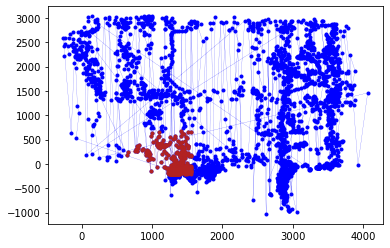

In [308]:
xx = df1.loc[df1.x_grid>=10].loc[df1.x_grid<=20].loc[df1.y_grid>=10].loc[df1.y_grid<=20].x
yy = df1.loc[df1.x_grid>=10].loc[df1.x_grid<=20].loc[df1.y_grid>=10].loc[df1.y_grid<=20].y
#xx = df1.loc[df1.xy_grid>=20].loc[df1.xy_grid<=30]
#yy = df1.loc[df1.xy_grid>=20].loc[df1.xy_grid<=30]
#xx = df1.loc[df1.xy_grid>=483].loc[df1.xy_grid<=927].x
#yy = df1.loc[df1.xy_grid>=483].loc[df1.xy_grid<=927].y
plt.plot(df1.x, df1.y, color="blue", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.plot(xx, yy, color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show()

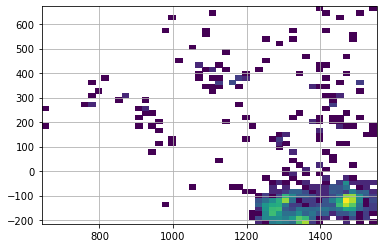

In [313]:
#df1.loc[df1.x_grid>=20].loc[df1.x_grid<=30].x
#df1.loc[df1.y_grid>=20].loc[df1.y_grid<=30].y
plt.hist2d(xx, yy, bins = 50, norm = colors.LogNorm())
plt.grid()
plt.show()

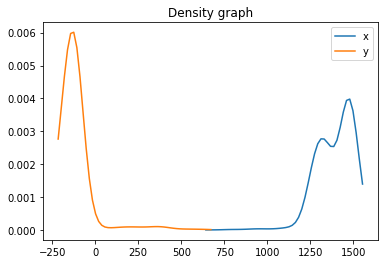

In [358]:
from scipy.stats import gaussian_kde
def density_graph(column):
    density = gaussian_kde(column)

    x_vals = np.linspace(column.min(),column.max(),50) # Specifying the limits of our data
    density.covariance_factor = lambda : .5 #Smoothing parameter

    density._compute_covariance()
    plt.title("Density graph")
    plt.plot(x_vals,density(x_vals), label=column.name)
    plt.legend()
    
#density_graph(df1['x_grid'])
#density_graph(df1['y_grid'])
density_graph(xx)
density_graph(yy)

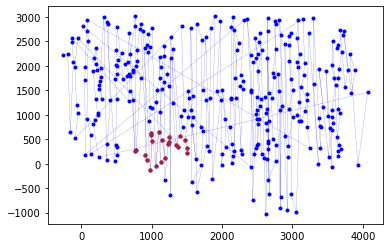

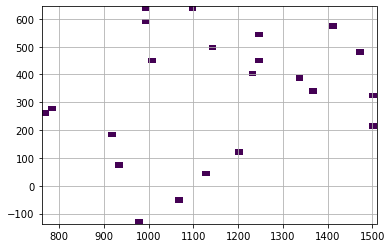

In [367]:
dftest = df1.copy()

dftest.sort_values(['x_grid', "y_grid"]).groupby('node_id')
dftest.drop_duplicates(subset=['y_grid', 'x_grid'], keep=False, inplace=True)

xx = dftest.loc[dftest.x_grid>=10].loc[dftest.x_grid<=20].loc[dftest.y_grid>=10].loc[dftest.y_grid<=20].x
yy = dftest.loc[dftest.x_grid>=10].loc[dftest.x_grid<=20].loc[dftest.y_grid>=10].loc[dftest.y_grid<=20].y

plt.plot(dftest.x, dftest.y, color="blue", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.plot(xx, yy, color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show()

plt.hist2d(xx, yy, bins = 50, norm = colors.LogNorm())
plt.grid()
plt.show()

# Outliers using isolation forest

In [10]:
df1 = isolation_forest(df1, 800000, 0, .2)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (800000) is greater than the total number of samples (99827). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Dataframe lenght before: 99827


KeyError: '[   67   434   454   455   456   457   458   459  1673  1676  1679  1680\n  1691  1694  2099  3262  3263  3308  3397  3398  3399  3400  3424  3892\n  3927  3928  6159  6160  6161  7156  7174  7388  7464  7465  7468  7470\n  7471  8091  8739  8740  8741  8743 26553 46094 46096 46097 46098 48939\n 84376 84377 84378 84379 84380 93126 93127 93130] not found in axis'

# Cleaning Node_id, timestamp, q, z columns

In [18]:
df1 = clean_dataframe(df1)
df1

# Adding xy_grid values to dataframe (50x50)

In [20]:
df1 = xy_to_grid(df1, df1.x, df1.y, 50)
df1